# Importing Libs

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import warnings
warnings.filterwarnings('ignore')

**Specify the `exportdate` below**

In [2]:
exportdate = pd.Timestamp('2023-06-27T12')

# Computing Feature 1: Warningsign

## Importing dataset

Place all your "file.csv" files in a folder named files and then use its path as mentioned below

In [3]:
directory = 'files'  # Replace with the actual path to your directory

df_deal = pd.DataFrame()  # Initialize an empty DataFrame for Deal data
df_case = pd.DataFrame()  # Initialize an empty DataFrame for Case data

for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Check if the file is a CSV
        file_path = os.path.join(directory, filename)  # Get the full file path

        # Read the CSV file into a DataFrame
        data = pd.read_csv(file_path)

        # Check if "ChangeToWonTime" or "DoneTime" columns exist in the DataFrame
        if 'ChangeToWonTime' in data.columns:
            # Append the DataFrame to df_deal
            df_deal = pd.concat([df_deal, data], ignore_index=True)
        if 'DoneTime' in data.columns:
            # Append the DataFrame to df_case
            df_case = pd.concat([df_case, data], ignore_index=True)
            
ExpireDate = pd.read_csv(r"Training Data\ExpireDate.csv", dtype={"Id": str})
ExpireDate = ExpireDate.rename(columns={'Id':'BizDomainId','RegisterTime':'BizRegisterDate','ExpirationDate':'BizExpireDate' , 'LastAccessTime':'BizAccessDate'})
ExpireDate['BizDomainId'] = ExpireDate['BizDomainId'].str.lower()

date_columns = ['BizRegisterDate', 'BizExpireDate', 'BizAccessDate']

for column in date_columns:
    ExpireDate[column] = pd.to_datetime(ExpireDate[column]).dt.date

In [4]:
ExpireDate.head()

,BizDomainId,BizRegisterDate,BizExpireDate,BizAccessDate,PipelineId,Type
0,28710004-7957-4cae-8528-2e45bd62bbe9,2021-05-07,2022-05-22,2022-12-01,B5C6E741-BAB5-493C-84DE-8F08444B8545,1
1,28710004-7957-4cae-8528-2e45bd62bbe9,2021-05-07,2022-05-22,2022-12-01,9888CED4-CBD0-413B-8984-CCE6DB61E920,0
2,28710004-7957-4cae-8528-2e45bd62bbe9,2021-05-07,2022-05-22,2022-12-01,D72956E2-2471-4739-AEB5-E745D4E0E0B3,1
3,1374a992-1317-4bd8-8129-874374a25f2b,2021-05-07,2022-05-22,2023-04-19,7B3C4C1B-2BFD-4437-8C00-9C50A2D24EF1,1
4,1374a992-1317-4bd8-8129-874374a25f2b,2021-05-07,2022-05-22,2023-04-19,2D347D79-B7F3-4988-B2B2-F4D8BC069F9A,0


defining a fucntion to change the dates of `df_case` for their pipelines

In [5]:
def CaseFeature1(df , expdate = ExpireDate):
    # rename columns
    df = df.rename(columns={'IsDeleted':'IsDeletedCase','Id':'CaseId' , 'Id.1':'ActivityId','IsDeleted.1':'IsDeletedActivity','RegisterTime':'RegisterTimeCase','Status':'StatusCase',
                            'DoneTime': 'DoneTimeCase','RegisterDate':'RegisterDateActivity','IsDone':'IsDoneActivity', 'DoneDate':'DoneDateActivity'})

    # manipulate columns
    df['BizDomainId'] = df['BizDomainId'].astype('string')
    df['CaseId'] = df['CaseId'].astype('string')
    df['BizDomainId'] = df['BizDomainId'].str.lower()
    df['CaseId'] = df['CaseId'].str.lower()

    df['DoneDateActivity'] = np.where(df['IsDoneActivity']==0 , np.nan ,df['DoneDateActivity'])
    df['CaseFinishTime']=np.where(df['StatusCase']==2 , df['DoneTimeCase'] , None)
    df['temp_max'] = np.nanmax(df[['RegisterDateActivity' , 'DoneDateActivity' , 'CaseFinishTime' , 'RegisterTimeCase']].fillna('00'), axis=1)
    df['temp_min'] = np.nanmin(df[['RegisterDateActivity' , 'DoneDateActivity' , 'CaseFinishTime' , 'RegisterTimeCase']].fillna('2050-01-01'), axis=1)
    df['temp_max'] = pd.to_datetime(df['temp_max'], errors='coerce')
    df['temp_min'] = pd.to_datetime(df['temp_min'], errors='coerce')
    df = df.dropna(subset=['temp_min', 'temp_max'], how='any')
    df.drop(['temp_min' , 'temp_max'] , axis = 1 ,inplace=True)

    # convert date/time columns to datetime dtype
    df['RegisterDateActivity'] = pd.to_datetime(df['RegisterDateActivity'])
    df['DoneDateActivity'] = pd.to_datetime(df['DoneDateActivity'])
    df['RegisterTimeCase'] = pd.to_datetime(df['RegisterTimeCase'])
    df['CaseFinishTime'] = pd.to_datetime(df['CaseFinishTime'])

    # drop columns
    df.drop(['ActivityId' , 'DoneTimeCase'], axis=1, inplace=True)
    
    #----------------------------------------------------------------------------
    
    # merge the expiration date data, Type=1 denotes cases
    expdate = expdate[expdate['Type']==1].drop(columns=['Type'])
    df = pd.merge(df, expdate, how='left' , on = ['PipelineId' , 'BizDomainId'])

    # Determine whether the business is expired
    df['BizIsExpired?'] = np.where(df['BizExpireDate'] >= exportdate, 0, 1)

    # Keep the bizdomains that last longer than 2 months
    from dateutil.relativedelta import relativedelta
    df = df[df['BizRegisterDate'] <= (exportdate - relativedelta(months=2))]

    # Delete data where IsDeletedCase=1 and StatusCase=1 (Pending)
    mask = df.query('IsDeletedCase == 1 and StatusCase == 1').index
    # shape1 = len(df)
    df = df.loc[~df.index.isin(mask)]
    # shape2 = len(df)
    # print(f"Number of deleted cases: {shape1-shape2}, number of rows before: {shape1}, number of rows after: {shape2}")
    
    #----------------------------------------------------------------------------
    
    def apply_function(df):
        mask = (df['StatusCase'] == 1) & (df['IsDeletedCase'] == 0)
        expired_mask = mask & (df['BizIsExpired?'] == 1)
        df.loc[expired_mask, 'CaseFinishTime'] = np.minimum(df.loc[expired_mask, 'BizExpireDate'], df.loc[expired_mask, 'BizAccessDate'])
        df.loc[expired_mask & (df['IsDoneActivity'] == 0) & (df['IsDeletedActivity'] == 0), 'DoneDateActivity'] = df.loc[expired_mask, 'CaseFinishTime']
        df.loc[mask & ~(df['BizIsExpired?'] == 1), 'CaseFinishTime'] = exportdate
        df.loc[mask & ~(df['BizIsExpired?'] == 1) & (df['IsDoneActivity'] == 0) & (df['IsDeletedActivity'] == 0), 'DoneDateActivity'] = exportdate
        df.drop(columns=['BizAccessDate' , 'BizExpireDate' , 'BizRegisterDate'], inplace=True)
        return df

    df = apply_function(df)

    #----------------------------------------------------------------------------
    
    # Function for Fixing the order of the times of occurrence
    # DealStartTime<ActivityStartTime<ActivityFinishTime<DealFinishTime
    
    df['RegisterTimeCase']=np.minimum(df['RegisterTimeCase'] , df['CaseFinishTime'])
    mask = ~pd.isna(df['RegisterDateActivity'])
    df.loc[mask, 'RegisterDateActivity'] = np.maximum(df.loc[mask, 'RegisterTimeCase'] ,  
                                        np.minimum(df.loc[mask,'RegisterDateActivity'] , df.loc[mask,'CaseFinishTime']))
    df.loc[mask , 'DoneDateActivity'] = np.minimum(df.loc[mask,'CaseFinishTime'] ,  
                                        np.maximum(df.loc[mask,'RegisterTimeCase'] , df.loc[mask,'DoneDateActivity']))
    df.loc[mask,'DoneDateActivity'] = np.maximum(df.loc[mask,'RegisterDateActivity'] , df.loc[mask , 'DoneDateActivity'])
    
    # Activity: IsDone=0, IsDeleted=1
    mask = (df['IsDoneActivity']==0) & (df['IsDeletedActivity']==1)
    df = df.loc[~mask ,:]
    
    #----------------------------------------------------------------------------
    
    # Completing finish time of activities
    
    # Calculate average of other activities of Case
    df['diff'] = (df['DoneDateActivity'] - df['RegisterDateActivity']).dt.total_seconds()
    df['avg_diff_Case'] = df['diff'].groupby(df['CaseId']).transform(lambda x: np.nanmean(x))
    mask_Case = pd.isna(df['DoneDateActivity']) & (df.groupby('CaseId')['CaseId'].transform('size') > 1)
    df.loc[mask_Case, 'DoneDateActivity'] = df.loc[mask_Case, 'RegisterDateActivity'] + pd.to_timedelta(df.loc[mask_Case, 'avg_diff_Case'], unit='s')
    df.drop(columns=['diff', 'avg_diff_Case'], inplace=True)

    # Calculate average of other activities of biz
    df['diff'] = (df['DoneDateActivity'] - df['RegisterDateActivity']).dt.total_seconds()
    df['avg_diff_biz'] = df['diff'].groupby(df['BizDomainId']).transform(lambda x: np.nanmean(x))
    mask_biz = pd.isna(df['DoneDateActivity'])
    df.loc[mask_biz, 'DoneDateActivity'] = df.loc[mask_biz, 'RegisterDateActivity'] + pd.to_timedelta(df.loc[mask_biz, 'avg_diff_biz'], unit='s')
    df.drop(columns=['diff', 'avg_diff_biz'], inplace=True)

    # Clip DoneDateActivity to CaseFinishTime
    df['DoneDateActivity'] = np.minimum(df['DoneDateActivity'], df['CaseFinishTime'])
    
    return df

In [6]:
df_case = CaseFeature1(df_case)

defining a fucntion to change the dates of `df_deal` for their pipelines

In [8]:
def DealFeature1(df , expdate = ExpireDate):
    
    # rename columns
    df = df.rename(columns={'IsDeleted':'IsDeletedDeal','Id':'DealId' , 'Id.1':'ActivityId','IsDeleted.1':'IsDeletedActivity','RegisterTime':'RegisterTimeDeal',
                            'Status':'StatusDeal','RegisterDate':'RegisterDateActivity','IsDone':'IsDoneActivity','DoneDate':'DoneDateActivity'})

    # manipulate columns
    df['BizDomainId'] = df['BizDomainId'].str.lower()
    df['DealId'] = df['DealId'].str.lower()
    df['DoneDateActivity'] = np.where(df['IsDoneActivity']==False , np.nan ,df['DoneDateActivity'])
    df['DealFinishTime'] = np.where(df['StatusDeal']==1 , df['ChangeToWonTime'] , np.where(df['StatusDeal']==2 , df['ChangeToLossTime'] , None))
    
    df['temp_max'] = np.nanmax(df[['RegisterDateActivity' , 'DoneDateActivity' , 'DealFinishTime' , 'RegisterTimeDeal']].fillna('00'), axis=1)
    df['temp_min'] = np.nanmin(df[['RegisterDateActivity' , 'DoneDateActivity' , 'DealFinishTime' , 'RegisterTimeDeal']].fillna('2050-01-01'), axis=1)
    df['temp_max'] = pd.to_datetime(df['temp_max'], errors='coerce')
    df['temp_min'] = pd.to_datetime(df['temp_min'], errors='coerce')
    df = df.dropna(subset=['temp_min', 'temp_max'], how='any')
    df.drop(['temp_min' , 'temp_max'] , axis = 1 ,inplace=True)
    
    # convert date/time columns to datetime dtype
    df['RegisterDateActivity'] = pd.to_datetime(df['RegisterDateActivity'])
    df['DoneDateActivity'] = pd.to_datetime(df['DoneDateActivity'])
    df['RegisterTimeDeal'] = pd.to_datetime(df['RegisterTimeDeal'])
    df['DealFinishTime'] = pd.to_datetime(df['DealFinishTime'])

    # drop columns
    df.drop(['ChangeToWonTime' , 'ChangeToLossTime' , 'ActivityId'], axis=1, inplace=True)
    
    #----------------------------------------------------------------------------

    # merge the expiration date data, Type=0 denotes Deals
    expdate = expdate[expdate['Type']==0].drop(columns=['Type'])
    df = pd.merge(df, expdate, how='left' , on = ['PipelineId' , 'BizDomainId'])

    # Determine whether the business is expired
    df['BizIsExpired?'] = np.where(df['BizExpireDate'] >= exportdate, 0, 1)

    # Keep the bizdomains that last longer than 2 months
    from dateutil.relativedelta import relativedelta
    df = df[df['BizRegisterDate'] <= (exportdate - relativedelta(months=2))]

    # Delete data where IsDeletedDeal=1 and StatusDeal=0
    mask = df.query('IsDeletedDeal == 1 and StatusDeal == 0').index
    # shape1 = len(df)
    df = df.loc[~df.index.isin(mask)]
    # shape2 = len(df)
    # print(f"Number of deleted cases: {shape1-shape2}, number of rows before: {shape1}, number of rows after: {shape2}")
    #----------------------------------------------------------------------------
    def apply_function(df):
        mask = (df['StatusDeal'] == 0) & (df['IsDeletedDeal'] == 0)
        expired_mask = mask & (df['BizIsExpired?'] == 1)
        df.loc[expired_mask, 'DealFinishTime'] = np.minimum(df.loc[expired_mask, 'BizExpireDate'], df.loc[expired_mask, 'BizAccessDate'])
        df.loc[expired_mask & (df['IsDoneActivity'] == 0) & (df['IsDeletedActivity'] == 0), 'DoneDateActivity'] = df.loc[expired_mask, 'DealFinishTime']
        df.loc[mask & ~(df['BizIsExpired?'] == 1), 'DealFinishTime'] = exportdate
        df.loc[mask & ~(df['BizIsExpired?'] == 1) & (df['IsDoneActivity'] == 0) & (df['IsDeletedActivity'] == 0), 'DoneDateActivity'] = exportdate
        df.drop(columns=['BizAccessDate' , 'BizExpireDate' , 'BizRegisterDate'], inplace=True)
        return df

    df = apply_function(df)
    #----------------------------------------------------------------------------
    # Function for Fixing the order of the times of occurrence
    # DealStartTime<ActivityStartTime<ActivityFinishTime<DealFinishTime
    
    df['RegisterTimeDeal']=np.minimum(df['RegisterTimeDeal'] , df['DealFinishTime'])
    mask = ~pd.isna(df['RegisterDateActivity'])
    df.loc[mask, 'RegisterDateActivity'] = np.maximum(df.loc[mask, 'RegisterTimeDeal'] ,
                                        np.minimum(df.loc[mask,'RegisterDateActivity'] , df.loc[mask,'DealFinishTime']))
    df.loc[mask , 'DoneDateActivity'] = np.minimum(df.loc[mask,'DealFinishTime'] ,
                                        np.maximum(df.loc[mask,'RegisterTimeDeal'] , df.loc[mask,'DoneDateActivity']))
    df.loc[mask,'DoneDateActivity'] = np.maximum(df.loc[mask,'RegisterDateActivity'] , df.loc[mask , 'DoneDateActivity'])
    
    # Activity: IsDone=0, IsDeleted=1
    mask = (df['IsDoneActivity']==0) & (df['IsDeletedActivity']==1)
    df = df.loc[~mask ,:]
    #----------------------------------------------------------------------------

    # Completing finish time of activities
    # Calculate average of other activities of deal
    df['diff'] = (df['DoneDateActivity'] - df['RegisterDateActivity']).dt.total_seconds()
    df['avg_diff_deal'] = df['diff'].groupby(df['DealId']).transform(lambda x: np.nanmean(x))
    mask_deal = pd.isna(df['DoneDateActivity']) & (df.groupby('DealId')['DealId'].transform('size') > 1)
    df.loc[mask_deal, 'DoneDateActivity'] = df.loc[mask_deal, 'RegisterDateActivity'] + pd.to_timedelta(df.loc[mask_deal, 'avg_diff_deal'], unit='s')
    df.drop(columns=['diff', 'avg_diff_deal'], inplace=True)

    # Calculate average of other activities of biz
    df['diff'] = (df['DoneDateActivity'] - df['RegisterDateActivity']).dt.total_seconds()
    df['avg_diff_biz'] = df['diff'].groupby(df['BizDomainId']).transform(lambda x: np.nanmean(x))
    mask_biz = pd.isna(df['DoneDateActivity'])
    df.loc[mask_biz, 'DoneDateActivity'] = df.loc[mask_biz, 'RegisterDateActivity'] + pd.to_timedelta(df.loc[mask_biz, 'avg_diff_biz'], unit='s')
    df.drop(columns=['diff', 'avg_diff_biz'], inplace=True)

    # Clip DoneDateActivity to DealFinishTime
    df['DoneDateActivity'] = np.minimum(df['DoneDateActivity'], df['DealFinishTime'])
    
    return df

In [9]:
df_deal = DealFeature1(df_deal)

Concating `df_case` and `df_deal` for further processes, `Case` & `Deal` in column names are all changed into `Deal`.

In [10]:
df_case = df_case.rename(columns=lambda x: x.replace('Case', 'Deal'))
df = pd.concat([df_deal, df_case])

#Removing the unnecessary columns
df.drop(columns = ['IsDeletedDeal' , 'StatusDeal' , 'IsDeletedActivity' , 'IsDoneActivity'] , inplace=True)

## Export Cleaned Dataset

Export data based on the shape of the df, each 1,000,000 rows should be saved a separate csv file

In [11]:
os.makedirs('files_cleaned', exist_ok=True)
for i, chunk in enumerate(df.groupby(np.arange(len(df)) // 1000000)):
    chunk[1].to_csv(f'files_cleaned/df_file_cleaned{i+1}.csv', index=False)

**Importing the cleaned dataset**

Change the directory of exported data to `files_cleaned` and then use the cell below if you desire to use them. Exporting should be done because the cleaned dataset will be used in future Feature Extractions.

In [12]:
# path = r"files_cleaned" # use your path
# all_files = glob.glob(os.path.join(path , "*.csv"))

# li = []

# for filename in all_files:
#     df = pd.read_csv(filename, index_col=0, header=0)
#     li.append(df)

# df = pd.concat(li, axis=0, ignore_index=True)
# df.loc[:, ['RegisterTimeDeal' , 'DealFinishTime','RegisterDateActivity','DoneDateActivity']] = df.loc[:,['RegisterTimeDeal' , 'DealFinishTime','RegisterDateActivity','DoneDateActivity']].apply(pd.to_datetime)
# df.head()

Function for calculating the metric of proportion of warning time to total deal time

In [13]:
def merge_times(intervals):
    intervals.sort(key=lambda x: x[0])

    res = [intervals[0]]
    for idx in range(1, len(intervals)):
        curr = intervals[idx]
        prev = res[-1]

        # Check for overlap
        if prev[1] < curr[0]:  # No overlap
            res.append(curr)
        else:
            # Overlap, update end time
            prev[1] = max(prev[1], curr[1])

    return res

def no_warning_ratio(start_time, end_time, intervals):
    '''
    input:
    start_time = RegisterTime of a deal
    end_time = DealFinishTime
    intervals = related intervals for activities on a specific deal
    
    ----------------------
    
    output:
    a dictionary with the following keys:
    - 'no_warning_ratio': ratio of (not showing warning signal)/(duration of the deal)
    - 'deal_duration': duration of the deal in seconds
    '''
    end_time_int = pd.Timedelta(end_time - start_time).total_seconds()

    if pd.isna(intervals.iloc[0, 0]):
        return {'no_warning_ratio': 0, 'deal_duration': end_time_int}
    elif end_time_int == 0:
        return {'no_warning_ratio': 0, 'deal_duration': 0}
    else:
        intervals = intervals.sub(start_time).apply(lambda x: x.dt.total_seconds()).values.tolist()
        merged = merge_times(intervals)
        with_activity = np.sum(end - start for start, end in merged)
        ratio = with_activity / end_time_int
        return {'no_warning_ratio': ratio, 'deal_duration': end_time_int}


def metric_activation_function(df):
    '''
    input:
    dataframe of the groupby function applied to DealIds
    
    ----------------------
    
    output:
    a dictionary with the following keys:
    - 'BizDomainId': the ID of the business domain
    - 'PipelineId': the ID of the Pipeline of the Deal
    - 'DealId': the ID of the deal
    - 'metric': the no_warning_ratio for the deal
    - 'DealDuration': the duration of the deal in seconds
    '''
    BizId = df.loc[:, 'BizDomainId'].values[0]
    PipelineId = df.loc[: , 'PipelineId'].values[0]
    DealId = df.loc[:, 'DealId'].values[0]
    start_time = df.loc[:, 'RegisterTimeDeal'].values[0]
    end_time = df.loc[:, 'DealFinishTime'].values[0]
    intervals = df.loc[:, ['RegisterDateActivity', 'DoneDateActivity']]
    res = no_warning_ratio(start_time, end_time, intervals)
    return {'BizDomainId': BizId,'PipelineId':PipelineId ,'DealId': DealId, 'metric': res['no_warning_ratio'], 'DealDuration': res['deal_duration']}


metric = df.groupby('DealId').apply(metric_activation_function)
metric = pd.DataFrame(metric.tolist())

Aggregating for BizId by the means of Calculating expectation (weighted average)

In [14]:
def AggreagtorPipelineId(df):
    BizId = df.loc[: , 'BizDomainId'].values[0]
    PipelineId=df.loc[:,'PipelineId'].values[0]
    if np.sum(df['DealDuration'])==0:
        return {'BizDomainId': BizId,'PipelineId':PipelineId , 'no_warning_sign':0}
    else:
        return {'BizDomainId': BizId,'PipelineId': PipelineId , 'no_warning_sign':
               np.sum(df['metric']*df['DealDuration'])/df['DealDuration'].sum()}
    
final_df = metric.groupby('PipelineId').apply(AggreagtorPipelineId)
final_df = pd.DataFrame(final_df.tolist())

## Output Feature 1

In [15]:
final_df = pd.merge(final_df , df[['BizDomainId','PipelineId','BizIsExpired?']] , how='left',
                    on = ['BizDomainId' , 'PipelineId'])
final_df = final_df.drop_duplicates().rename(columns={'no_warning_sign':'WarningSign'})
final_df['WarningSign'] = 1-final_df['WarningSign']
final_df = final_df.loc[: , ['BizDomainId' , 'PipelineId' , 'BizIsExpired?' , 'WarningSign']]
os.makedirs('Notebooks Data Process', exist_ok=True)
final_df['PipelineId'] = final_df['PipelineId'].str.lower()
final_df['WarningSign'] = final_df['WarningSign'].clip(lower=0)
final_df.to_csv('Notebooks Data Process/1. WarningSign.csv',index=0)

# Computing Other Features

importing cleaned files

In [16]:
path = r"files_cleaned" # use your path
all_files = glob.glob(os.path.join(path , "*.csv"))

li = [pd.read_csv(filename,dtype={'BizDomainId': 'string', 'DealId': 'string' , 'PipelineId':'string'},parse_dates=[
    'RegisterTimeDeal' , 'DealFinishTime','RegisterDateActivity','DoneDateActivity']) for filename in all_files]

file_cleaned = pd.concat(li, axis=0, ignore_index=True)
file_cleaned.head()

,BizDomainId,PipelineId,DealId,RegisterTimeDeal,RegisterDateActivity,DoneDateActivity,DealFinishTime,BizIsExpired?
0,dc329e4a-dfc8-4f88-8221-b6fabebc0f8c,A24243B3-C0D0-474D-8626-237CBA8ED28E,f4873f96-e641-4001-b157-9073dc212f39,2023-05-29 10:24:21,2023-05-29 10:24:21,2023-05-29 10:24:21.000,2023-06-23 11:56:05,0
1,3543cb3b-e043-404f-9ff8-039b09ee39ba,FA86586A-2F47-478C-AF1A-CEDD90D2706A,42792665-680b-4b0e-b00a-49204971e2ed,2023-05-01 09:56:23,2023-05-01 09:59:36,2023-05-01 10:48:47.600,2023-05-01 12:35:28,0
2,77bc456d-aa85-40b0-8d09-c9fbee0066f2,57B37CA9-3F47-487F-BAB7-D72A08D9D6E2,35bd762e-2e33-4fdf-964d-7b4459d81891,2023-05-25 07:12:00,2023-06-08 10:57:41,2023-06-10 09:00:21.000,2023-06-20 08:36:13,0
3,08fec101-b47d-4950-b00b-f9f6aabef808,002BE8C6-E9E5-48CB-B2FC-D8DBF110EE4A,daf0ec45-7bba-4786-ade1-74043b085d98,2023-06-10 10:57:33,2023-06-11 09:10:24,2023-06-27 12:00:00.000,2023-06-27 12:00:00,0
4,bc580e44-a387-42f7-8017-052e656bdd24,CBD13369-EC6D-45F5-9A57-A39B78A346ED,29880d6d-4414-4a83-b075-81a84eefaddd,2023-05-19 01:10:01,2023-05-28 08:29:33,2023-05-28 08:29:33.000,2023-06-27 12:00:00,0


Importing Feature 1 Final Dataset and ExpireDataset

In [17]:
from dateutil.relativedelta import relativedelta
df = pd.read_csv(r"Notebooks Data Process/1. WarningSign.csv")
expire = pd.read_csv(r"Training Data/ExpireDate.csv").rename(columns={'Id':'BizDomainId'})
expire[['BizDomainId' , 'PipelineId']] = expire[['BizDomainId' , 'PipelineId']].apply(lambda x: x.str.lower(),axis=1)

date_columns = ['RegisterTime', 'ExpirationDate', 'LastAccessTime']
for column in date_columns:
    expire[column] = pd.to_datetime(expire[column]).dt.date
    
expire = expire[expire['RegisterTime'] <= (exportdate - relativedelta(months=2))]
more_than_2months_biz = expire['BizDomainId'].tolist()
df = pd.merge(expire[['BizDomainId', 'PipelineId' , 'RegisterTime','ExpirationDate' , 'Type']] , df , on = ['BizDomainId' , 'PipelineId']
            , how='left')
df['BizIsExpired?']=np.where(df['ExpirationDate']>=exportdate,0,1)
df.head()

,BizDomainId,PipelineId,RegisterTime,ExpirationDate,Type,BizIsExpired?,WarningSign
0,28710004-7957-4cae-8528-2e45bd62bbe9,b5c6e741-bab5-493c-84de-8f08444b8545,2021-05-07,2022-05-22,1,1,NaN
1,28710004-7957-4cae-8528-2e45bd62bbe9,9888ced4-cbd0-413b-8984-cce6db61e920,2021-05-07,2022-05-22,0,1,NaN
2,28710004-7957-4cae-8528-2e45bd62bbe9,d72956e2-2471-4739-aeb5-e745d4e0e0b3,2021-05-07,2022-05-22,1,1,NaN
3,1374a992-1317-4bd8-8129-874374a25f2b,7b3c4c1b-2bfd-4437-8c00-9c50a2d24ef1,2021-05-07,2022-05-22,1,1,NaN
4,1374a992-1317-4bd8-8129-874374a25f2b,2d347d79-b7f3-4988-b2b2-f4d8bc069f9a,2021-05-07,2022-05-22,0,1,NaN


## #Activities & #Deals

In [18]:
df5_1 = pd.read_csv(r"Training Data\Deals - Last Month.csv")
df5_2 = pd.read_csv(r"Training Data\Deals - 2 Month ago.csv")
df5_1[['BizDomainId','PipelineId']] = df5_1[['BizDomainId','PipelineId']].apply(lambda x: x.str.lower(),axis=1)
df5_2[['BizDomainId','PipelineId']] = df5_2[['BizDomainId','PipelineId']].apply(lambda x: x.str.lower(),axis=1)
df5 = pd.merge(df5_1 , df5_2 , how='outer', on=['BizDomainId' , 'PipelineId'])
df5['#Deals_2months'] = df5['LastMonth'].fillna(0)+df5['TwoMonthsAgo'].fillna(0)
df = pd.merge(df , df5[['BizDomainId' , 'PipelineId' ,'#Deals_2months']] , how='left' , on=['BizDomainId' , 'PipelineId'])

df6_1 = pd.read_csv(r"Training Data\Activities - Last Month.csv")
df6_2 = pd.read_csv(r"Training Data\Activities - 2 Month ago.csv")
df6_1[['BizDomainId','PipelineId']] = df6_1[['BizDomainId','PipelineId']].apply(lambda x: x.str.lower(),axis=1)
df6_2[['BizDomainId','PipelineId']] = df6_2[['BizDomainId','PipelineId']].apply(lambda x: x.str.lower(),axis=1)
df6 = pd.merge(df6_1 , df6_2 , how='outer', on=['BizDomainId' , 'PipelineId'])
df6['#Activities_2months'] = df6['LastMonth'].fillna(0)+df6['TwoMonthsAgo'].fillna(0)
df = pd.merge(df , df6[['BizDomainId' , 'PipelineId' ,'#Activities_2months']] , how='left' , on=['BizDomainId' , 'PipelineId'])
df_act = file_cleaned.groupby(['BizDomainId','PipelineId'])['DealId'].agg('count').reset_index().rename(columns={'DealId':'#Activities_files'})
df_deal = file_cleaned.groupby(['BizDomainId','PipelineId'])['DealId'].nunique().reset_index().rename(columns={'DealId':'#Deals_files'})
df = pd.merge(df , df_act , on=['BizDomainId' , 'PipelineId'] , how='left')
df = pd.merge(df , df_deal , on=['BizDomainId' , 'PipelineId'] , how='left')

df['#Deals'] = np.maximum(df['#Deals_2months'].fillna(0) , df['#Deals_files'].fillna(0))
df['#Activities'] = np.maximum(df['#Activities_2months'].fillna(0), df['#Activities_files'].fillna(0))
df.drop(columns=['#Deals_2months','#Deals_files','#Activities_2months','#Activities_files'],inplace=True)
df.head()

,BizDomainId,PipelineId,RegisterTime,ExpirationDate,Type,BizIsExpired?,WarningSign,#Deals,#Activities
0,28710004-7957-4cae-8528-2e45bd62bbe9,b5c6e741-bab5-493c-84de-8f08444b8545,2021-05-07,2022-05-22,1,1,NaN,0.0,0.0
1,28710004-7957-4cae-8528-2e45bd62bbe9,9888ced4-cbd0-413b-8984-cce6db61e920,2021-05-07,2022-05-22,0,1,NaN,0.0,0.0
2,28710004-7957-4cae-8528-2e45bd62bbe9,d72956e2-2471-4739-aeb5-e745d4e0e0b3,2021-05-07,2022-05-22,1,1,NaN,0.0,0.0
3,1374a992-1317-4bd8-8129-874374a25f2b,7b3c4c1b-2bfd-4437-8c00-9c50a2d24ef1,2021-05-07,2022-05-22,1,1,NaN,0.0,0.0
4,1374a992-1317-4bd8-8129-874374a25f2b,2d347d79-b7f3-4988-b2b2-f4d8bc069f9a,2021-05-07,2022-05-22,0,1,NaN,0.0,0.0


## Feature 2: ActiveUsers/AddedUsers

In [19]:
# df_3 = pd.read_csv(r"Training Data\Active-Add-Ratio.csv",parse_dates = ['Date'])
# df_3['BizdomainId'] = df_3['BizdomainId'].str.lower()
# df_3 = df_3.query('Date <= @exportdate')
# df_3['ActiveUsers/AddedUsers'] = df_3['ActiveUsers'] / df_3['TotalUsersAdded']
# df_3 = df_3.groupby('BizdomainId')['ActiveUsers/AddedUsers'].mean().reset_index()

# df = pd.merge(df, df_3.rename(columns={'BizdomainId': 'BizDomainId'})[['BizDomainId', 'ActiveUsers/AddedUsers']],
#               how='left', on='BizDomainId')
# df.head()

## Feature 3: TransformationSpeed related (Pending/Whole Deal)

In [20]:
filenames = [r"Training Data\TransSpeed – PendingDeal.csv", r"Training Data\TransSpeed – WholeDeal.csv"]
filenames2 = [r"Training Data\TransSpeed - PendingDeal.csv", r"Training Data\TransSpeed - WholeDeal.csv"]
try:
    df41, df42 = [pd.read_csv(filename) for filename in filenames]
except FileNotFoundError:
    df41, df42 = [pd.read_csv(filename) for filename in filenames2]


df41[['BizDomainId','PipelineId']] = df41[['BizDomainId','PipelineId']].apply(lambda x: x.str.lower(),axis=1)
df42[['BizDomainId','PipelineId']] = df42[['BizDomainId','PipelineId']].apply(lambda x: x.str.lower(),axis=1)

df4 = df42.merge(df41, on=['BizDomainId','PipelineId'], how='left')
df4['PendingDeal'].fillna(0, inplace=True)
df4['Pending/Whole_TransSpeed'] = df4['PendingDeal'] / df4['WholeDeal']

df = df.merge(df4[['BizDomainId', 'PipelineId' ,'Pending/Whole_TransSpeed']], 
              on=['BizDomainId' , 'PipelineId'], how='left')

In [21]:
df.head()

,BizDomainId,PipelineId,RegisterTime,ExpirationDate,Type,BizIsExpired?,WarningSign,#Deals,#Activities,Pending/Whole_TransSpeed
0,28710004-7957-4cae-8528-2e45bd62bbe9,b5c6e741-bab5-493c-84de-8f08444b8545,2021-05-07,2022-05-22,1,1,NaN,0.0,0.0,NaN
1,28710004-7957-4cae-8528-2e45bd62bbe9,9888ced4-cbd0-413b-8984-cce6db61e920,2021-05-07,2022-05-22,0,1,NaN,0.0,0.0,NaN
2,28710004-7957-4cae-8528-2e45bd62bbe9,d72956e2-2471-4739-aeb5-e745d4e0e0b3,2021-05-07,2022-05-22,1,1,NaN,0.0,0.0,NaN
3,1374a992-1317-4bd8-8129-874374a25f2b,7b3c4c1b-2bfd-4437-8c00-9c50a2d24ef1,2021-05-07,2022-05-22,1,1,NaN,0.0,0.0,NaN
4,1374a992-1317-4bd8-8129-874374a25f2b,2d347d79-b7f3-4988-b2b2-f4d8bc069f9a,2021-05-07,2022-05-22,0,1,NaN,0.0,0.0,NaN


## Feature 4: DealsRatio

In [22]:
df5_1 = pd.read_csv(r"Training Data\Deals - Last Month.csv")
df5_2 = pd.read_csv(r"Training Data\Deals - 2 Month ago.csv")

df5_1[['BizDomainId','PipelineId']] = df5_1[['BizDomainId','PipelineId']].apply(lambda x: x.str.lower(),axis=1)
df5_2[['BizDomainId','PipelineId']] = df5_2[['BizDomainId','PipelineId']].apply(lambda x: x.str.lower(),axis=1)

df5 = pd.merge(df5_1 , df5_2 , how='outer', on=['BizDomainId' , 'PipelineId'])
df5['TwoMonthsAgo'].fillna(1 , inplace=True)
df5['LastMonth'].fillna(0 , inplace=True)
df5['DealsRatio'] = df5['LastMonth'] / df5['TwoMonthsAgo']

df = pd.merge(df , df5[['BizDomainId' , 'PipelineId' ,'DealsRatio']] , how='left' , on=['BizDomainId' , 'PipelineId'])
df.head()

,BizDomainId,PipelineId,RegisterTime,ExpirationDate,Type,BizIsExpired?,WarningSign,#Deals,#Activities,Pending/Whole_TransSpeed,DealsRatio
0,28710004-7957-4cae-8528-2e45bd62bbe9,b5c6e741-bab5-493c-84de-8f08444b8545,2021-05-07,2022-05-22,1,1,NaN,0.0,0.0,NaN,NaN
1,28710004-7957-4cae-8528-2e45bd62bbe9,9888ced4-cbd0-413b-8984-cce6db61e920,2021-05-07,2022-05-22,0,1,NaN,0.0,0.0,NaN,NaN
2,28710004-7957-4cae-8528-2e45bd62bbe9,d72956e2-2471-4739-aeb5-e745d4e0e0b3,2021-05-07,2022-05-22,1,1,NaN,0.0,0.0,NaN,NaN
3,1374a992-1317-4bd8-8129-874374a25f2b,7b3c4c1b-2bfd-4437-8c00-9c50a2d24ef1,2021-05-07,2022-05-22,1,1,NaN,0.0,0.0,NaN,NaN
4,1374a992-1317-4bd8-8129-874374a25f2b,2d347d79-b7f3-4988-b2b2-f4d8bc069f9a,2021-05-07,2022-05-22,0,1,NaN,0.0,0.0,NaN,NaN


## Feature 5: ActivitiesRatio

In [23]:
df6_1 = pd.read_csv(r"Training Data\Activities - Last Month.csv")
df6_2 = pd.read_csv(r"Training Data\Activities - 2 Month ago.csv")

df6_1[['BizDomainId','PipelineId']] = df6_1[['BizDomainId','PipelineId']].apply(lambda x: x.str.lower(),axis=1)
df6_2[['BizDomainId','PipelineId']] = df6_2[['BizDomainId','PipelineId']].apply(lambda x: x.str.lower(),axis=1)

df6 = pd.merge(df6_1 , df6_2 , how='outer', on=['BizDomainId' , 'PipelineId'])
df6['TwoMonthsAgo'].fillna(1 , inplace=True)
df6['LastMonth'].fillna(0 , inplace=True)
df6['ActivitiesRatio'] = df6['LastMonth'] / df6['TwoMonthsAgo']
df = pd.merge(df , df6[['BizDomainId' , 'PipelineId' ,'ActivitiesRatio']] , how='left' , on=['BizDomainId' , 'PipelineId'])
df.head()

,BizDomainId,PipelineId,RegisterTime,ExpirationDate,Type,BizIsExpired?,WarningSign,#Deals,#Activities,Pending/Whole_TransSpeed,DealsRatio,ActivitiesRatio
0,28710004-7957-4cae-8528-2e45bd62bbe9,b5c6e741-bab5-493c-84de-8f08444b8545,2021-05-07,2022-05-22,1,1,NaN,0.0,0.0,NaN,NaN,NaN
1,28710004-7957-4cae-8528-2e45bd62bbe9,9888ced4-cbd0-413b-8984-cce6db61e920,2021-05-07,2022-05-22,0,1,NaN,0.0,0.0,NaN,NaN,NaN
2,28710004-7957-4cae-8528-2e45bd62bbe9,d72956e2-2471-4739-aeb5-e745d4e0e0b3,2021-05-07,2022-05-22,1,1,NaN,0.0,0.0,NaN,NaN,NaN
3,1374a992-1317-4bd8-8129-874374a25f2b,7b3c4c1b-2bfd-4437-8c00-9c50a2d24ef1,2021-05-07,2022-05-22,1,1,NaN,0.0,0.0,NaN,NaN,NaN
4,1374a992-1317-4bd8-8129-874374a25f2b,2d347d79-b7f3-4988-b2b2-f4d8bc069f9a,2021-05-07,2022-05-22,0,1,NaN,0.0,0.0,NaN,NaN,NaN


## Output of other features

In [24]:
# os.mkdir('Notebooks Data Process')
df.to_csv('Notebooks Data Process/2. all features.csv',index=0)

# Feature Engineering

In [25]:
df = pd.read_csv(r"Notebooks Data Process/2. all features.csv")
# WarningSign: 
## NaN values of this columns are replaced with 1
df.loc[: , 'WarningSign'].fillna(1 , inplace=True)

# ActivitiesRatio & DealsRatio
## Worst values are 0
## Bizdomains didnt register any activity/deal in the past 2 months
df.loc[: , 'DealsRatio'].fillna(0 , inplace=True)
df.loc[: , 'ActivitiesRatio'].fillna(0 , inplace=True)


# Pending/Whole_TransSpeed
## NaN means no deals for the last 3 months
df['Pending/Whole_TransSpeed'].fillna(inplace=True , value=1)


# DealsRatio
name= 'DealsRatio'
df[name] = df[name].clip(upper=1)

# ActivitiesRatio
name= 'ActivitiesRatio'
df[name] = df[name].clip(upper=1)

## Making all Features Consistent
The higher the values in each columns, the better the performance

In [26]:
df[['WarningSign' , 'Pending/Whole_TransSpeed']] = 1-df[['WarningSign' , 'Pending/Whole_TransSpeed']]

In [27]:
df.to_csv('Notebooks Data Process/3. Feature_Engineered.csv',index=0)

# Health Score

In [28]:
df.head()

,BizDomainId,PipelineId,RegisterTime,ExpirationDate,Type,BizIsExpired?,WarningSign,#Deals,#Activities,Pending/Whole_TransSpeed,DealsRatio,ActivitiesRatio
0,28710004-7957-4cae-8528-2e45bd62bbe9,b5c6e741-bab5-493c-84de-8f08444b8545,2021-05-07,2022-05-22,1,1,0.0,0.0,0.0,0.0,0.0,0.0
1,28710004-7957-4cae-8528-2e45bd62bbe9,9888ced4-cbd0-413b-8984-cce6db61e920,2021-05-07,2022-05-22,0,1,0.0,0.0,0.0,0.0,0.0,0.0
2,28710004-7957-4cae-8528-2e45bd62bbe9,d72956e2-2471-4739-aeb5-e745d4e0e0b3,2021-05-07,2022-05-22,1,1,0.0,0.0,0.0,0.0,0.0,0.0
3,1374a992-1317-4bd8-8129-874374a25f2b,7b3c4c1b-2bfd-4437-8c00-9c50a2d24ef1,2021-05-07,2022-05-22,1,1,0.0,0.0,0.0,0.0,0.0,0.0
4,1374a992-1317-4bd8-8129-874374a25f2b,2d347d79-b7f3-4988-b2b2-f4d8bc069f9a,2021-05-07,2022-05-22,0,1,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
df = pd.read_csv(r'Notebooks Data Process/3. Feature_Engineered.csv').drop(
    columns=['RegisterTime' , 'ExpirationDate','BizIsExpired?' , '#Deals' , '#Activities'])

# best practices & weights
best = [1 , 1 , 1 , 1 ]
weights_1 = [0.286835, 0.271913, 0.234662, 0.206589]

# Health Score
from scipy.spatial.distance import euclidean
df['Health_Score'] = np.around(1 - df.iloc[:,3:].apply(lambda x: euclidean(x , best , weights_1) , axis=1),decimals=4)*10

cols_to_round = df.columns.drop(['BizDomainId' , 'Health_Score'])
df.loc[: , cols_to_round] = np.around(df.loc[: , cols_to_round] , decimals=3)
df.head()

,BizDomainId,PipelineId,Type,WarningSign,Pending/Whole_TransSpeed,DealsRatio,ActivitiesRatio,Health_Score
0,28710004-7957-4cae-8528-2e45bd62bbe9,b5c6e741-bab5-493c-84de-8f08444b8545,1,0.0,0.0,0.0,0.0,0.0
1,28710004-7957-4cae-8528-2e45bd62bbe9,9888ced4-cbd0-413b-8984-cce6db61e920,0,0.0,0.0,0.0,0.0,0.0
2,28710004-7957-4cae-8528-2e45bd62bbe9,d72956e2-2471-4739-aeb5-e745d4e0e0b3,1,0.0,0.0,0.0,0.0,0.0
3,1374a992-1317-4bd8-8129-874374a25f2b,7b3c4c1b-2bfd-4437-8c00-9c50a2d24ef1,1,0.0,0.0,0.0,0.0,0.0
4,1374a992-1317-4bd8-8129-874374a25f2b,2d347d79-b7f3-4988-b2b2-f4d8bc069f9a,0,0.0,0.0,0.0,0.0,0.0


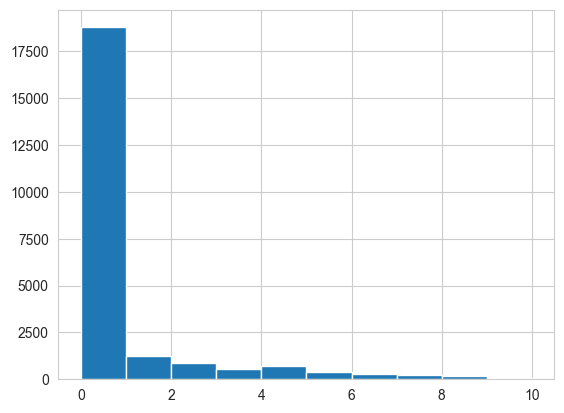

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure()
sns.set_style('whitegrid')
plt.hist(df['Health_Score'] ,bins=10)
plt.show()

Output

In [32]:
# Replace values of Type columns:
replacement_map = {0: 'Deal', 1: 'Case'}
df['Type'] = df['Type'].map(replacement_map)

df.to_csv('Notebooks Data Process/4. Health_Score_Pipeline.csv',index=0)